# Prédiction des risques 

In [1]:
!pip install pandas numpy scikit-learn imbalanced-learn seaborn matplotlib

  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.15.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc, brier_score_loss
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("BankChurners.csv", usecols=list(range(0,21)))
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [7]:
# Encodage des variables catégorielles
ordinal_enc_variables = ["Education_Level", "Income_Category", "Card_Category"]
one_hot_enc_variables = ["Gender", "Marital_Status"]

edu_lvl = ["Unknown", "Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"]
income_cat = ["Unknown", "Less than $40K", "$40K - $60K", "$80K - $120K", "$60K - $80K", "$120K +"]
card_cat = ["Blue", "Silver", "Gold", "Platinum"]

df_encoded = df.copy()
ord_enc = OrdinalEncoder(categories=[edu_lvl, income_cat, card_cat])
df_encoded[ordinal_enc_variables] = ord_enc.fit_transform(df_encoded[ordinal_enc_variables])

# Utilisation de sparse_output au lieu de sparse
one_hot_enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
one_hot_enc_df = pd.DataFrame(one_hot_enc.fit_transform(df_encoded[one_hot_enc_variables]))
one_hot_enc_df.columns = one_hot_enc.get_feature_names_out(one_hot_enc_variables)  # Utilisation de get_feature_names_out
df_encoded = pd.concat([df_encoded.drop(one_hot_enc_variables, axis=1), one_hot_enc_df], axis=1)

# Séparation des données
X = df_encoded.drop(["Attrition_Flag", "CLIENTNUM"], axis=1)
y = df_encoded["Attrition_Flag"]
y.replace(to_replace=["Existing Customer", "Attrited Customer"], value=[0, 1], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/tmp/ipykernel_105303/3050951734.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace(to_replace=["Existing Customer", "Attrited Customer"], value=[0, 1], inplace=True)


In [8]:
# Rééchantillonnage avec RandomOverSampler
resampler = RandomOverSampler()
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)

# Sélection de caractéristiques avec RFECV
model = RandomForestClassifier()
selector = RFECV(model, step=1, min_features_to_select=5, cv=10)
selector.fit(X_train_resampled, y_train_resampled)
X_train_selected = selector.transform(X_train_resampled)
X_test_selected = selector.transform(X_test)

In [9]:
# Définition des hyperparamètres à optimiser
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['sqrt', None],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

# Recherche aléatoire des hyperparamètres
search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=50,
    scoring='recall',
    n_jobs=-1,
    cv=4,
    random_state=1
)
search.fit(X_train_selected, y_train_resampled)

# Meilleurs hyperparamètres
print(search.best_params_)

{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [10]:
# Initialisation du modèle avec les meilleurs hyperparamètres
best_model = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=20,
    random_state=42
)

# Entraînement du modèle sur les données rééchantillonnées
best_model.fit(X_train_selected, y_train_resampled)

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=50,
                       random_state=42)

In [11]:
# Prédiction des classes (0 ou 1) sur l'ensemble de test
y_pred = best_model.predict(X_test_selected)

# Prédiction des probabilités pour la courbe ROC
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

Accuracy: 0.960
Precision: 0.900
Recall: 0.851
F1 Score: 0.875
AUC-ROC: 0.990


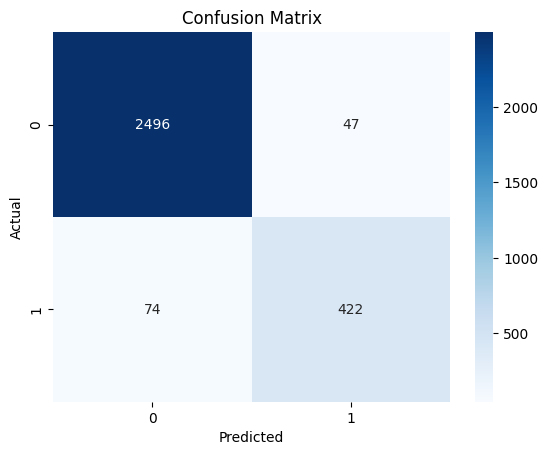

In [12]:
# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Affichage des résultats
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC-ROC: {roc_auc:.3f}")

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Ajout des prédictions au dataframe de test
df_test = X_test.copy()
df_test['Attrition_Prediction'] = y_pred

# Filtrage des clients prédits comme "à risque" (classe 1)
clients_a_risque = df_test[df_test['Attrition_Prediction'] == 1]
print(f"Nombre de clients à risque : {len(clients_a_risque)}")

# Affichage des clients à risque
clients_a_risque.head()

Nombre de clients à risque : 469


,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Attrition_Prediction
3994,48,4,3.0,3.0,0.0,32,5,2,3,25190.0,...,41,0.323,0.000,0.0,1.0,0.0,1.0,0.0,0.0,1
5137,46,3,2.0,1.0,0.0,39,3,3,0,1801.0,...,42,0.400,0.175,1.0,0.0,0.0,1.0,0.0,0.0,1
303,48,4,3.0,4.0,2.0,33,2,2,3,34516.0,...,32,0.455,0.060,0.0,1.0,0.0,1.0,0.0,0.0,1
4540,39,1,4.0,1.0,0.0,26,3,3,1,1876.0,...,47,0.469,0.819,1.0,0.0,0.0,0.0,1.0,0.0,1
5933,50,1,4.0,1.0,0.0,36,1,3,4,2422.0,...,46,0.484,0.207,1.0,0.0,0.0,0.0,1.0,0.0,1


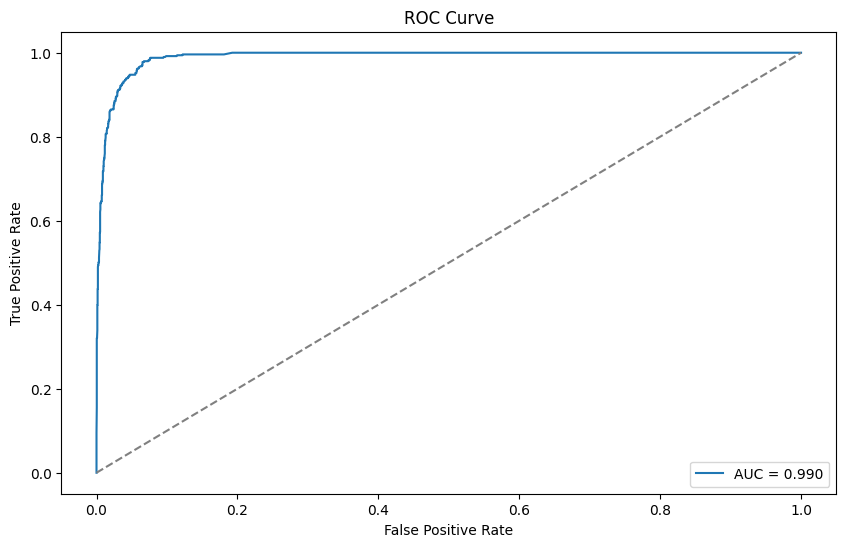

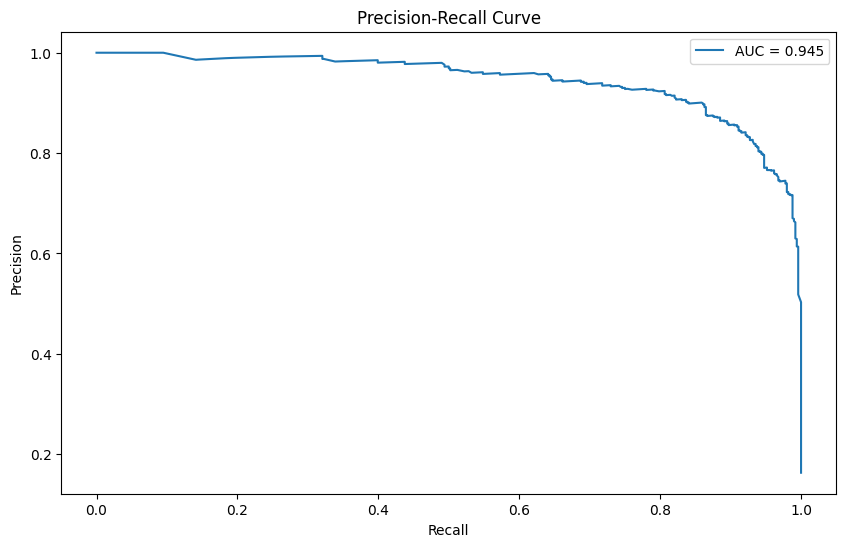

In [14]:
# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Courbe Precision-Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, label=f'AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()